In [225]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np



from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [226]:

batch_size = 100
take_latent_max =10
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 500
en_hidden2_dim = 500
en_hidden3_dim = 2000
latent_dim= 10
de_hidden1_dim = 2000
de_hidden2_dim = 500
de_hidden3_dim = 500


log_interval = 600

K_model_cluster = 10
K_real_cluster = 10

beta= 1.
beta_start = beta
beta_end = 1.
total_step = 500
beta_delta = (beta_end-beta_start)/total_step


save_folder = 'SGD-q-exponential'

KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

eps_N_c = 0
iter_adiabatic =1

qn_value =1

In [227]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)


In [228]:
def initialize_centers():

    mu_c = torch.randn(1,latent_dim,K_model_cluster,device=device)
    logvar_c = torch.zeros(1,latent_dim,K_model_cluster).to(device)
    inv_sm_pi_c = torch.zeros(1,1,K_model_cluster).to(device)

    return mu_c,logvar_c,inv_sm_pi_c

In [229]:


#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,inv_sm_pi_c_g = initialize_centers()
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_c_g.shape,inv_sm_pi_c_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]), torch.Size([1, 1, 10]))

In [230]:
mu_c_g.requires_grad_(True)
logvar_c_g.requires_grad_(True)
inv_sm_pi_c_g.requires_grad_(True)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       requires_grad=True)

In [231]:
mu_c_g.requires_grad,logvar_c_g.requires_grad,inv_sm_pi_c_g.requires_grad
#F.softmax(inv_sm_pi_c_g,dim=0)

(True, True, True)

In [232]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)##728 => 500 for MNIST
        self.encode1_layer = nn.Linear(en_hidden1_dim,en_hidden2_dim)##500 => 500 for MNIST
        self.encode2_layer = nn.Linear(en_hidden2_dim,en_hidden3_dim)##500 => 2000 for MNIST
        self.mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST
        self.decode2_layer = nn.Linear(de_hidden1_dim,de_hidden2_dim)##2000 => 500 for MNIST
        self.decode3_layer = nn.Linear(de_hidden2_dim,de_hidden3_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(de_hidden3_dim,output_dim)##500 => 728 for MNIST

    def encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.mu_layer(en_h3), self.std_layer(en_h3)
    #入力から中心と分散の対数を作っている


    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        de_h1 = F.relu(self.decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている


    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている


model = VAE().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.002)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


#optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g,inv_sm_pi_c_g],lr=0.002)
optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g],lr=0.002)
scheduler_clustering = torch.optim.lr_scheduler.MultiStepLR(optimizer_clustering,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)




In [233]:
def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    mus = torch.cat((mus,mu_c_g.permute(2,1,0)),0)
    ts = torch.cat((ts,torch.arange(-1,-K_model_cluster-1,-1).to(device)),0)
    return zs,ts,mus,logvars


In [234]:
def gauss(mus,logvars,mu_c,logvar_c,inv_sm_pi_c,iter):

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2))/(logvar_c.exp())

            gamma_c = (F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp()))/((F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = (((F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P


In [235]:
def drawpoints(mus_numpy,ts_numpy):
    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(points,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,center_numpy,center_t_numpy):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color='black',s=50)

#    plt.xlim(-4,4)
#    plt.ylim(-4,4)
    plt.show()

In [236]:
def show_generated_samples_c(mu_c,logvar_c):
    for i in range(K_model_cluster):
        with torch.no_grad():
            sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_' + str(i) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [259]:
def q_exponential(x,n):
    if n==0:
        return x.exp()
    else:
        return (1. - x/n).pow(-n)

def q_log(x,n):
    if n==0:
        return x.log()
    else:
        return n*(x.pow(1./n)-1.)

In [267]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,inv_sm_pi_c_f):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    KLD = -(q_log((F.softmax(inv_sm_pi_c_f,dim=2)*(q_exponential(-0.5*((-1.+logvar_c_f-logvars_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True)),qn_value))).sum(2,keepdim=True),qn_value)).sum()
#    KLD = -(((F.softmax(inv_sm_pi_c_f,dim=2)*((-0.5*((-1.+logvar_c_f-logvars_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True))).exp())).sum(2,keepdim=True)).log()).sum()#+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp()))

    return BCE+beta*KLD

In [268]:
def train_c(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        optimizer_clustering.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る

#        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {}'.format(
#              epoch,batch_idx*len(data),len(train_loader.dataset),
#                100.*batch_idx/len(train_loader),
#                inv_sm_pi_c_g
#            ))

        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c_g,logvar_c_f=logvar_c_g,inv_sm_pi_c_f=inv_sm_pi_c_g)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #NNパラメータの更新

        optimizer_clustering.step()
        #NNクラスタリングパラメータの更新

#        print(mu_c_g)
#        print('var_c='.format(logvar_c_g.exp()))

#        print('mu={}'.format(mu.view(-1,latent_dim,1).squeeze()))
#        print('prec_c={}'.format((1./logvar_c_g.exp()).squeeze()))
#        print('quad={}'.format(((((mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1)).squeeze()))
#        print('quadvar={}'.format((((logvar.view(-1,latent_dim,1).exp())/(logvar_c_g.exp())).sum(1)).squeeze()))
#        print('expDKL={}'.format((-0.5*((logvar_c_g+(logvar.view(-1,latent_dim,1).exp()+(mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1,keepdim=True))).exp().squeeze()))
#        print('logDKL={}'.format((((F.softmax(inv_sm_pi_c_g,dim=2)*((-0.5*((logvar_c_g+(logvar.view(-1,latent_dim,1).exp()+(mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1,keepdim=True))).exp())).sum(2,keepdim=True)).log()).squeeze()))

        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

#        if batch_idx == 5:
#            break

In [269]:
def test_c(epoch,mu_c,logvar_c,inv_sm_pi_c):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,inv_sm_pi_c_f=inv_sm_pi_c).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [270]:
def train_c_epoch(epochs,mu_c,logvar_c,inv_sm_pi_c):
    for epoch in range(1, epochs +1):
        train_c(epoch,mu_c,logvar_c,inv_sm_pi_c)
        test_c(epoch,mu_c,logvar_c,inv_sm_pi_c)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく


In [271]:
mu_c_g,logvar_c_g,F.softmax(inv_sm_pi_c_g,dim=2)

(tensor([[[ 0.8587, -0.2963, -0.0259, -2.0805, -1.9805,  0.3792,  0.3139,
            0.7328,  0.3751,  0.3162],
          [ 0.0086, -0.2966,  0.6636, -1.4071, -1.1394,  0.1820,  1.3595,
            1.1142,  0.9943,  0.7404],
          [ 0.0610,  0.3618,  2.5476,  1.0795,  0.2777,  0.2561, -0.0251,
           -0.0538,  0.6325, -0.9857],
          [ 0.8546, -1.2434, -0.7616,  0.0425,  0.0470,  0.0574,  1.1267,
            0.0836, -0.1634,  2.2444],
          [-0.7704,  0.9418, -0.4838, -0.7327,  0.2674,  0.5566, -0.0674,
           -1.4427,  1.2591, -0.5528],
          [-0.5663,  1.0086, -0.5680,  1.3149,  0.3808, -0.9389,  0.0843,
           -1.3067, -0.5878,  0.1701],
          [ 0.2116, -1.3029, -0.1420, -0.2591,  0.8305,  1.8699, -0.6938,
            1.2232, -0.7215, -0.1968],
          [ 0.2387, -1.4313, -0.4851, -1.7939, -0.6697, -0.3206, -0.0074,
           -1.3076,  0.0218,  0.5201],
          [ 0.1199, -0.4809,  0.7699,  2.0407,  0.5355,  0.3350,  0.2635,
           -0.5075,  0

In [339]:
qn_value = 10000

In [340]:
for i in range(10):
    #train_c_epoch(epochs=1,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)

    train_c(epoch=i)
    test_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,inv_sm_pi_c=inv_sm_pi_c_g)
    scheduler.step()
    scheduler_clustering.step()

    beta += beta_delta


Train Epoch: 0 [0/60000 (0%)]	Loss: 88.858398
====> Test set loss: 1.0174
Train Epoch: 1 [0/60000 (0%)]	Loss: 91.798213
====> Test set loss: 1.0238
Train Epoch: 2 [0/60000 (0%)]	Loss: 91.667285
====> Test set loss: 1.0194
Train Epoch: 3 [0/60000 (0%)]	Loss: 91.060557
====> Test set loss: 0.9907
Train Epoch: 4 [0/60000 (0%)]	Loss: 93.964951
====> Test set loss: 0.9762
Train Epoch: 5 [0/60000 (0%)]	Loss: 93.439688
====> Test set loss: 1.0293
Train Epoch: 6 [0/60000 (0%)]	Loss: 91.950840
====> Test set loss: 0.9692
Train Epoch: 7 [0/60000 (0%)]	Loss: 91.604219
====> Test set loss: 0.9758
Train Epoch: 8 [0/60000 (0%)]	Loss: 95.458291
====> Test set loss: 0.9965
Train Epoch: 9 [0/60000 (0%)]	Loss: 90.767588
====> Test set loss: 0.9985


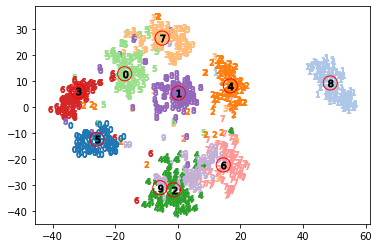

In [341]:
zs_g,ts_g,mus_g,logvars_g = take_latents()
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())
data_points = points[0:take_latent_max*batch_size]
center_points = points[take_latent_max*batch_size:]
data_labels = ts_g[0:take_latent_max*batch_size].cpu().detach().numpy()
center_labels = (-ts_g[take_latent_max*batch_size:]-1).cpu().detach().numpy()
drawpoints_with_centers(data_points,data_labels,center_points,center_labels)

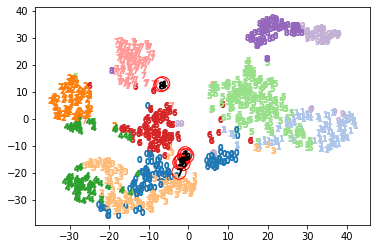

In [60]:
#kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,kmeans_model.labels_)
kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,kmeans_model.labels_[:take_latent_max*batch_size],center_points,center_labels)

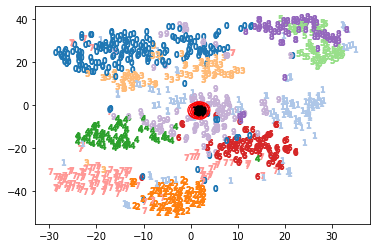

In [561]:
#gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy()))
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy())[:take_latent_max*batch_size],center_points,center_labels)

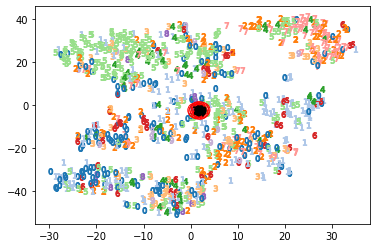

In [562]:

_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,inv_sm_pi_c_g,1)
#drawpoints(points[0:batch_size*take_latent_max,:],torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy())
#_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,chol_prec_seed_c_g,inv_sm_pi_c_g,1)
drawpoints_with_centers(data_points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy(),center_points,center_labels)

In [563]:
show_generated_samples_c(mu_c_g,logvar_c_g)

In [564]:
optimizer.param_groups[0]['lr'],optimizer_clustering.param_groups[0]['lr'],beta

(0.0018000000000000002, 0.0018000000000000002, 1.0)

In [565]:
correspond_matrix = torch.zeros(K_real_cluster,K_model_cluster)

for i in range(batch_size*take_latent_max):

    for j in range(K_model_cluster):
        for k in range(K_real_cluster):
            if torch.argmax(gamma_c_g,2)[i,0] == j:
                if ts_g[i] == k:
                    correspond_matrix[k,j] +=1


In [566]:
correspond_matrix

tensor([[29., 25.,  6.,  1.,  2., 17.,  4.,  0.,  4.,  0.],
        [ 8.,  3., 31.,  7.,  8., 15.,  3., 61.,  0.,  0.],
        [38., 11., 15.,  9.,  7.,  2., 11.,  5.,  0.,  4.],
        [16., 12., 22., 10.,  4.,  9.,  4., 15.,  1.,  2.],
        [16., 10.,  6.,  5.,  8., 52.,  2.,  6.,  0.,  1.],
        [ 9., 47.,  0.,  2.,  3., 11.,  8.,  0.,  0.,  0.],
        [21., 23.,  4., 22., 11., 14.,  8.,  2.,  3.,  1.],
        [17.,  7., 13.,  7.,  4., 31.,  8.,  4.,  0.,  4.],
        [ 9., 29., 11.,  4.,  3., 39.,  2.,  1.,  3.,  1.],
        [ 2.,  8.,  0.,  8.,  9., 53.,  1.,  4.,  1.,  1.]])

In [567]:
correspond_matrix.sum()

tensor(1000.)

In [568]:
torch.max(correspond_matrix,0)

torch.return_types.max(
values=tensor([38., 47., 31., 22., 11., 53., 11., 61.,  4.,  4.]),
indices=tensor([2, 5, 1, 6, 6, 9, 2, 1, 0, 2]))

In [569]:
torch.max(correspond_matrix,0).values.sum()/(batch_size*take_latent_max)

tensor(0.2820)

In [570]:
F.softmax(inv_sm_pi_c_g,dim=2)

tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [571]:
mu_c_g

tensor([[[-0.1452, -0.1452, -0.1452, -0.1452, -0.1452, -0.1452, -0.1452,
          -0.1452, -0.1452, -0.1452],
         [-0.2561, -0.2561, -0.2561, -0.2561, -0.2561, -0.2561, -0.2561,
          -0.2561, -0.2561, -0.2561],
         [ 0.2389,  0.2389,  0.2389,  0.2389,  0.2389,  0.2389,  0.2389,
           0.2389,  0.2389,  0.2389],
         [-0.1769, -0.1769, -0.1769, -0.1769, -0.1769, -0.1769, -0.1769,
          -0.1769, -0.1769, -0.1769],
         [ 1.1392,  1.1392,  1.1392,  1.1392,  1.1392,  1.1392,  1.1392,
           1.1392,  1.1392,  1.1392],
         [-0.5062, -0.5062, -0.5062, -0.5062, -0.5062, -0.5062, -0.5062,
          -0.5062, -0.5062, -0.5062],
         [ 0.0490,  0.0490,  0.0490,  0.0490,  0.0490,  0.0490,  0.0490,
           0.0490,  0.0490,  0.0490],
         [-0.5057, -0.5057, -0.5057, -0.5057, -0.5057, -0.5057, -0.5057,
          -0.5057, -0.5057, -0.5057],
         [-0.2288, -0.2288, -0.2288, -0.2288, -0.2288, -0.2288, -0.2288,
          -0.2288, -0.2288, -0.2288],
 

In [572]:
logvar_c_g.exp()

tensor([[[0.9412, 0.9412, 0.9412, 0.9412, 0.9412, 0.9412, 0.9412, 0.9412,
          0.9412, 0.9412],
         [0.3429, 0.3429, 0.3429, 0.3429, 0.3429, 0.3429, 0.3429, 0.3429,
          0.3429, 0.3429],
         [1.1744, 1.1744, 1.1744, 1.1744, 1.1744, 1.1744, 1.1744, 1.1744,
          1.1744, 1.1744],
         [0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
          0.8116, 0.8116],
         [0.3992, 0.3992, 0.3992, 0.3992, 0.3992, 0.3992, 0.3992, 0.3992,
          0.3992, 0.3992],
         [0.4182, 0.4182, 0.4182, 0.4182, 0.4182, 0.4182, 0.4182, 0.4182,
          0.4182, 0.4182],
         [0.3290, 0.3290, 0.3290, 0.3290, 0.3290, 0.3290, 0.3290, 0.3290,
          0.3290, 0.3290],
         [0.7869, 0.7869, 0.7869, 0.7869, 0.7869, 0.7869, 0.7869, 0.7869,
          0.7869, 0.7869],
         [0.4232, 0.4232, 0.4232, 0.4232, 0.4232, 0.4232, 0.4232, 0.4232,
          0.4232, 0.4232],
         [0.8263, 0.8263, 0.8263, 0.8263, 0.8263, 0.8263, 0.8263, 0.8263,
          0.8263,

In [573]:
mus_g[0:10,:,0]

tensor([[-2.5513, -0.5048,  0.6719,  1.0585,  0.6934, -0.4440,  0.4209,  0.4959,
         -0.7889, -0.7282],
        [-1.3693, -0.3280, -0.1139,  0.2216,  3.4536,  0.1681,  0.2944,  0.2648,
         -0.5379, -0.0114],
        [-0.6992, -0.7032, -0.6408, -1.1704,  0.3197,  0.3406,  0.4768, -0.8106,
          0.1277,  1.8721],
        [-1.0956, -1.1989, -0.3481, -0.2199,  0.3341, -0.2197,  0.0120, -0.4061,
         -0.6354,  1.6977],
        [-0.3312, -0.9793, -0.2534,  0.7284,  1.0004, -2.1813,  1.0505,  1.4738,
         -0.2670,  1.0236],
        [ 1.9103, -0.3269, -0.5325, -1.9085,  0.3254,  0.0496, -0.0317,  0.0566,
         -0.7073,  0.2225],
        [ 0.7952,  0.7157, -0.1182, -0.0175,  1.4087, -1.1215,  0.3862, -1.4075,
         -0.1080,  1.1068],
        [ 0.5715,  0.5015, -0.1273, -0.4668,  1.3422, -1.4986,  0.6882,  1.0162,
         -0.5566, -0.5529],
        [-1.0160, -0.3252,  1.1049,  0.0621,  1.3486, -1.8016, -0.7330,  0.7381,
         -0.6998,  0.2516],
        [ 1.7301, -

In [574]:
logvars_g.exp()[0:10,:,0]

tensor([[0.0026, 0.0091, 0.0039, 0.0023, 0.0024, 0.0057, 0.0134, 0.0027, 0.0062,
         0.0022],
        [0.0038, 0.0036, 0.0029, 0.0030, 0.0055, 0.0041, 0.0056, 0.0024, 0.0062,
         0.0016],
        [0.0032, 0.0025, 0.0019, 0.0032, 0.0014, 0.0035, 0.0046, 0.0017, 0.0034,
         0.0017],
        [0.0028, 0.0033, 0.0015, 0.0024, 0.0017, 0.0027, 0.0033, 0.0019, 0.0033,
         0.0014],
        [0.0023, 0.0055, 0.0020, 0.0027, 0.0018, 0.0038, 0.0035, 0.0026, 0.0044,
         0.0024],
        [0.0043, 0.0051, 0.0037, 0.0024, 0.0037, 0.0052, 0.0051, 0.0022, 0.0051,
         0.0045],
        [0.0055, 0.0051, 0.0030, 0.0053, 0.0055, 0.0057, 0.0084, 0.0033, 0.0072,
         0.0035],
        [0.0032, 0.0050, 0.0024, 0.0026, 0.0040, 0.0044, 0.0049, 0.0031, 0.0055,
         0.0061],
        [0.0024, 0.0069, 0.0036, 0.0021, 0.0052, 0.0079, 0.0098, 0.0033, 0.0068,
         0.0021],
        [0.0188, 0.0392, 0.0247, 0.0023, 0.0108, 0.0219, 0.1014, 0.0189, 0.0906,
         0.0670]], device='c

In [397]:
'''
torch.save(
    {
        "model_state_dict" : model.state_dict(),
        "optimizer" : optimizer.state_dict(),
        "optimizer_clustering" : optimizer_clustering.state_dict(),
        "mu_c_g" : mu_c_g,
        "logvar_c_g" : logvar_c_g,
        "inv_sm_pi_c_g" : inv_sm_pi_c_g,
        "beta" : beta,
        "K_model_cluster": K_model_cluster
    },
    "./SGD-q-exponential/model/success949.tar"
)
'''
#sdata966 = torch.load("./SGD-q-exponential/model/success966.tar")
#mu_c_g = sdata966["mu_c_g"]

'\ntorch.save(\n    {\n        "model_state_dict" : model.state_dict(),\n        "optimizer" : optimizer.state_dict(),\n        "optimizer_clustering" : optimizer_clustering.state_dict(),\n        "mu_c_g" : mu_c_g,\n        "logvar_c_g" : logvar_c_g,\n        "inv_sm_pi_c_g" : inv_sm_pi_c_g,\n        "beta" : beta,\n        "K_model_cluster": K_model_cluster\n    },\n    "./SGD-q-exponential/model/success949.tar"\n)\n'